# Well Location Selection

**Project Description:**

Imagine you are working for the mining company "GRGN" You need to decide where to drill a new well.

You are provided with oil samples from three regions, each containing 10,000 oil fields, where the quality of oil and the volume of reserves have been measured. Build a machine learning model to determine which region will yield the highest profit from extraction. Analyze potential profit and risks using the *Bootstrap* technique.

Steps for location selection:

- In the selected region, search for oil fields and determine feature values for each one;
- Build a model and estimate the volume of reserves;
- Select the oil fields with the highest estimated values. The number of fields depends on the company's budget and the cost of developing each well;
- Profit is the total sum of profits from the selected fields.


**Research Goal:**

To determine the region where extraction will yield the highest profit.

**Research Tasks:**

- Build a machine learning model to help identify the region with the highest profit from extraction.
- Analyze potential profit and risks using the *Bootstrap* technique.
- Propose a region for well development.

**Initial Data:**

Geological survey data for three regions are provided in the following files:  
/datasets/geo_data_0.csv  
/datasets/geo_data_1.csv  
/datasets/geo_data_2.csv

Columns in the dataset:
- id — unique identifier for each well;
- f0, f1, f2 — three feature values for each point;
- product — volume of reserves in the well (thousands of barrels).

**Task conditions:**
- Only linear regression can be used for model training (other models are not sufficiently predictable).
- During regional exploration, 500 points are investigated, from which 200 best points are selected for development using machine learning.
- The development budget for wells in the region is 10 billion rubles.
- At current prices, one barrel of raw material brings 450 rubles of income. The income per unit of product is 450 thousand rubles, as the volume is specified in thousands of barrels.
- After risk assessment, only regions with a loss probability of less than 2.5% should be retained. Among them, the region with the highest average profit should be selected.

The data is synthetic: contract details and characteristics of the deposits are not disclosed.


## Table of Contents

1. [Data Loading and Preparation](#data-loading-and-preparation)
2. [Model Training and Validation](#model-training-and-validation)
3. [Preparing for Profit Calculation](#preparing-for-profit-calculation)
4. [Profit and Risk Calculation](#profit-and-risk-calculation)
5. [Conclusions](#conclusions)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# pipeline class
from sklearn.pipeline import Pipeline

# data preprocessing classes
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import mean_squared_error

# RandomizedSearchCV, GridSearchCV classes
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

RANDOM_STATE=42
TEST_SIZE=0.25


In [2]:
import warnings 
warnings.simplefilter("ignore")

## Data Loading and Preparation

In [3]:
# region 0
data0 = pd.read_csv('/Users/dmslavin/Downloads/geo_data_0.csv')
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# region 1
data1 = pd.read_csv('/Users/dmslavin/Downloads/geo_data_1.csv')
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
# region 2
data2 = pd.read_csv('/Users/dmslavin/Downloads/geo_data_2.csv')
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
#duplicates check
print(data0.duplicated().sum())
print(data1.duplicated().sum())
print(data2.duplicated().sum())

0
0
0


In [10]:
#function for data analysis

def research(data):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    sb.histplot(data=data['f0'], kde=True, bins=30, ax=axes[0, 0])
    axes[0, 0].set_title('Feature f0 - histogram')
    sb.histplot(data=data['f1'], kde=True, bins=30, ax=axes[0, 1])
    axes[0, 1].set_title('Feature f1 - histogram')
    sb.histplot(data=data['f2'], kde=True, bins=30, ax=axes[1, 0])
    axes[1, 0].set_title('Feature f2 - histogram')
    sb.histplot(data=data['product'], bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Volume of reserves in the well (thousands of barrels) - histogram')

    plt.tight_layout()
    plt.show()
    
    print('Numerical description of the data\n')
    print(data.describe())
    
    # матрица диаграмм рассеяния
    print('Scatter plot matrix\n')
    pd.plotting.scatter_matrix(data.drop('id', axis=1), figsize=(12, 12))
    plt.show()
    
    # корреляция между признаками
    print('\nCorrelation between features')
    sb.heatmap(data.drop('id', axis=1).corr(method='spearman'), annot=True, fmt='.2f') 
    plt.show()
    

    

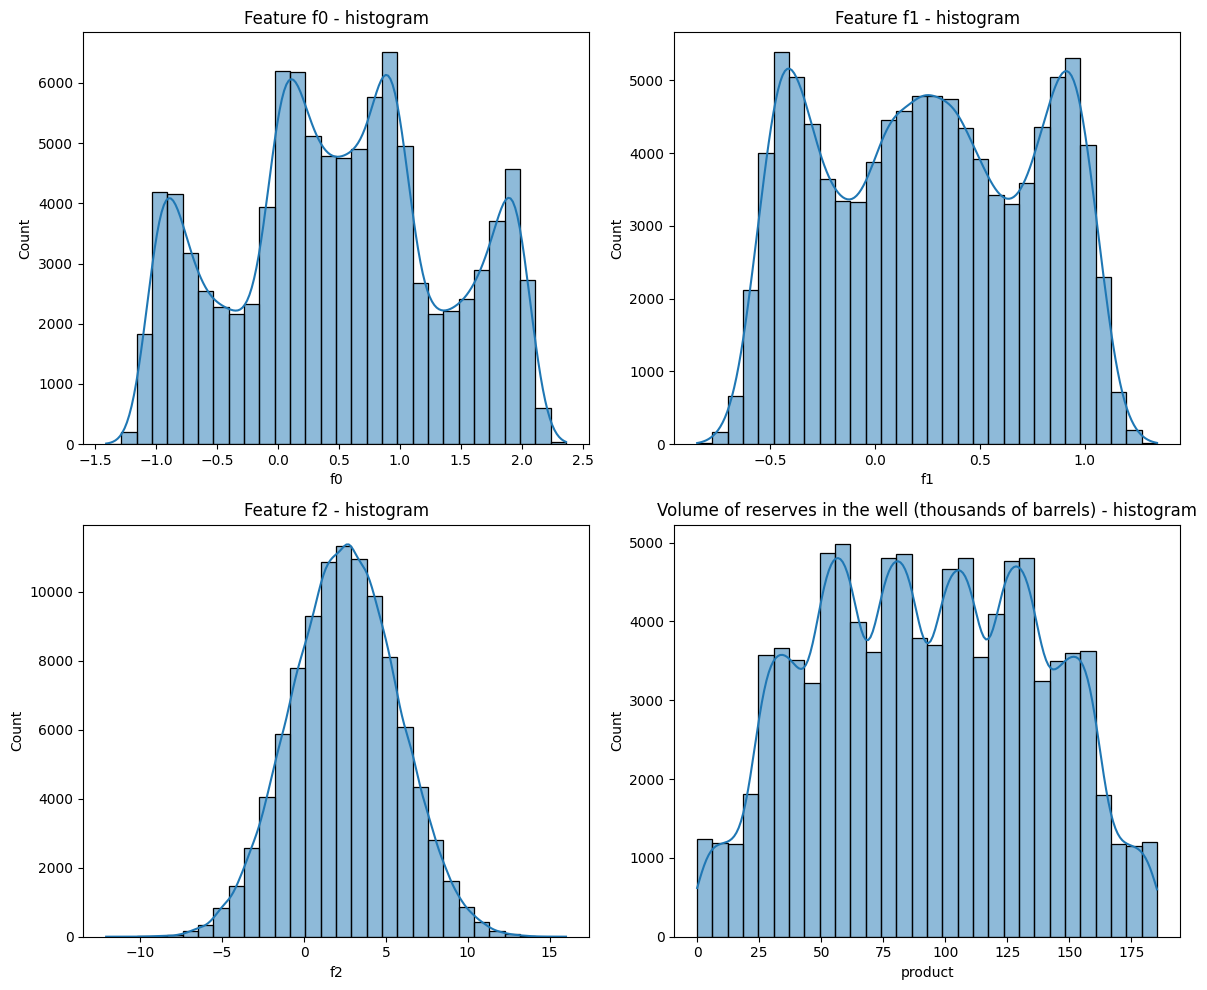

Numerical description of the data

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
Scatter plot matrix



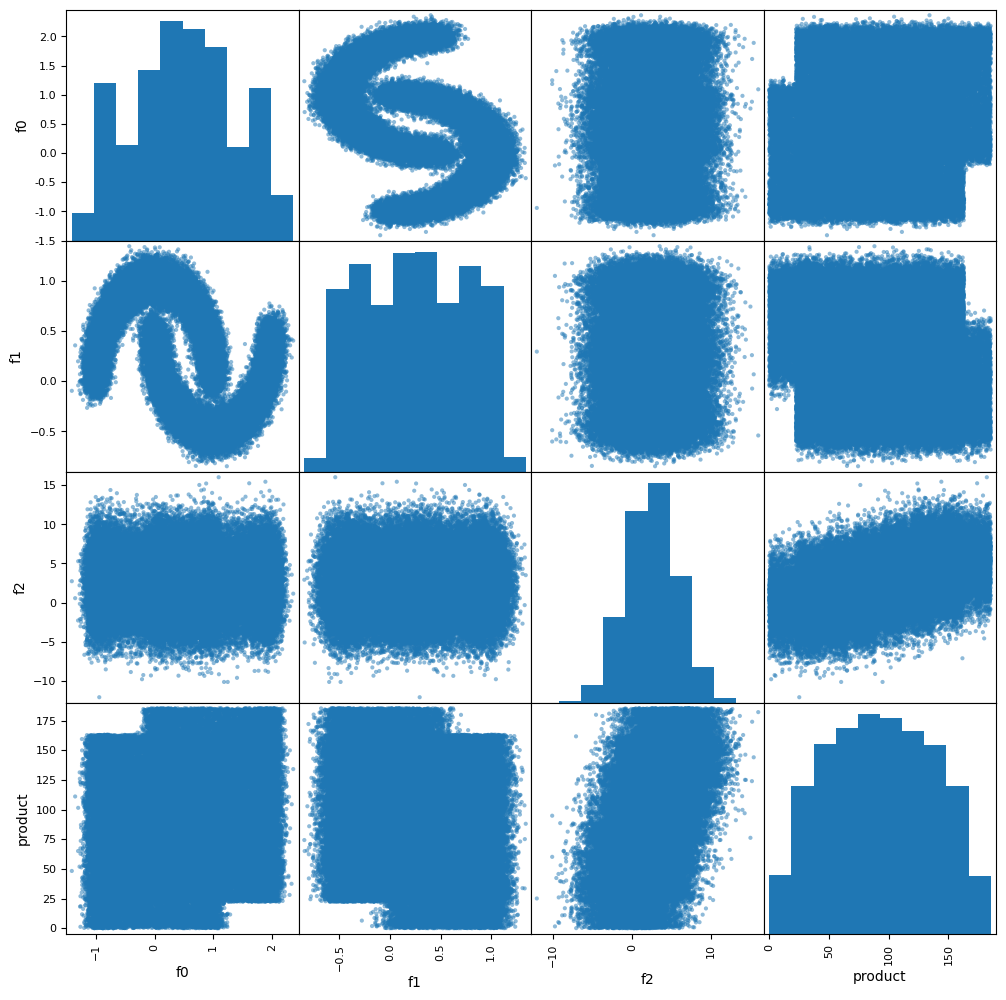


Correlation between features


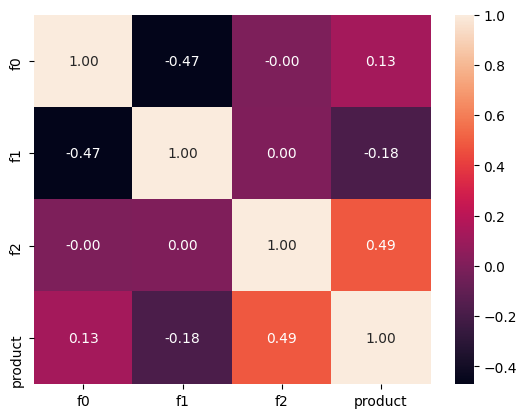

In [11]:
# exploring data for region 0
research(data0)

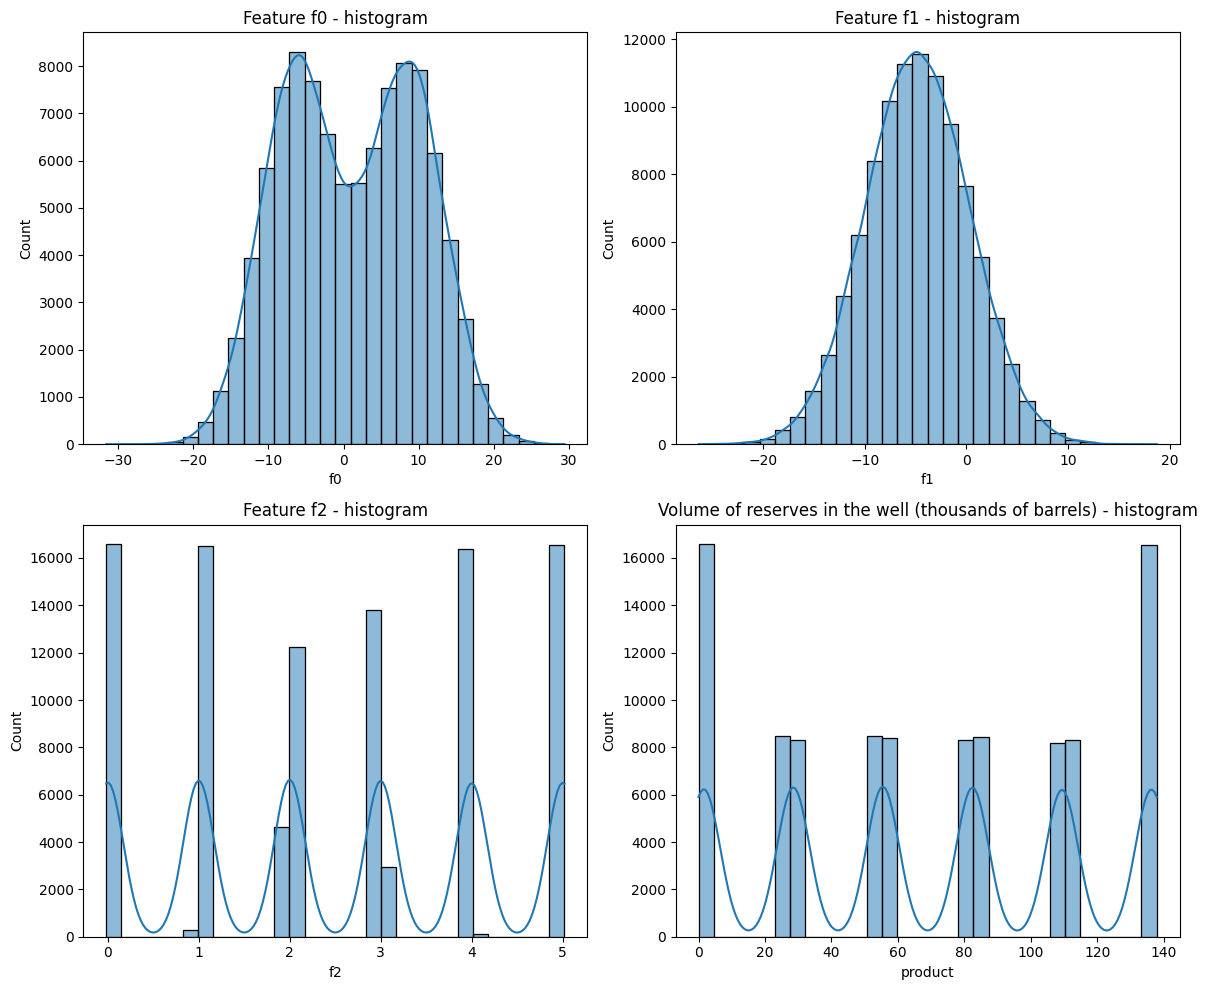

Numerical description of the data

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408
Scatter plot matrix



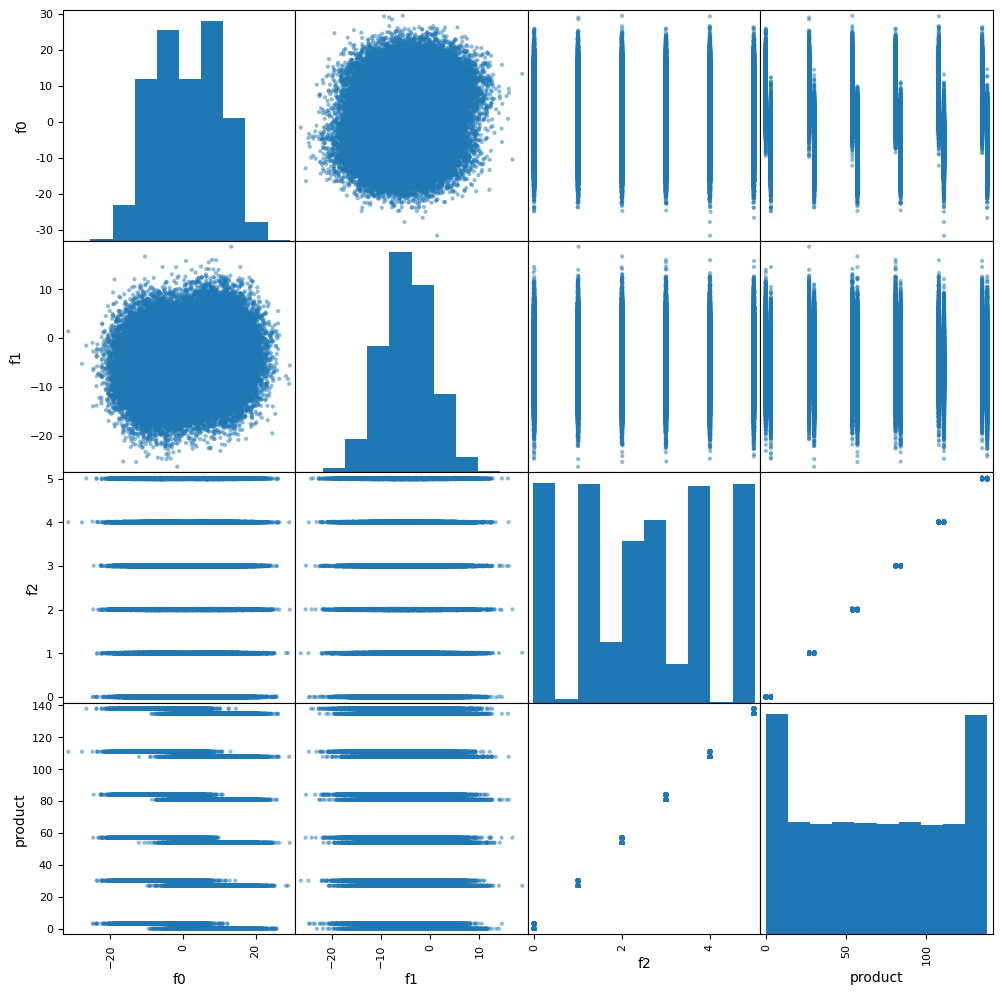


Correlation between features


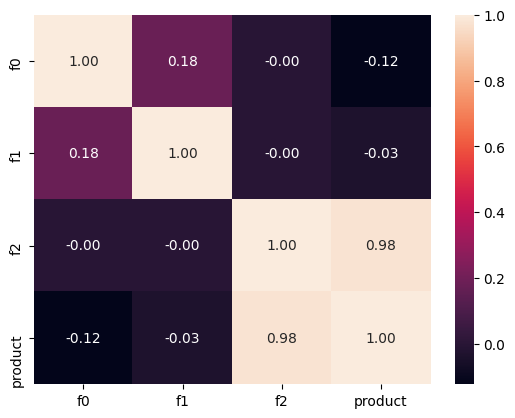

In [12]:
# exploring data for region 1
research(data1)

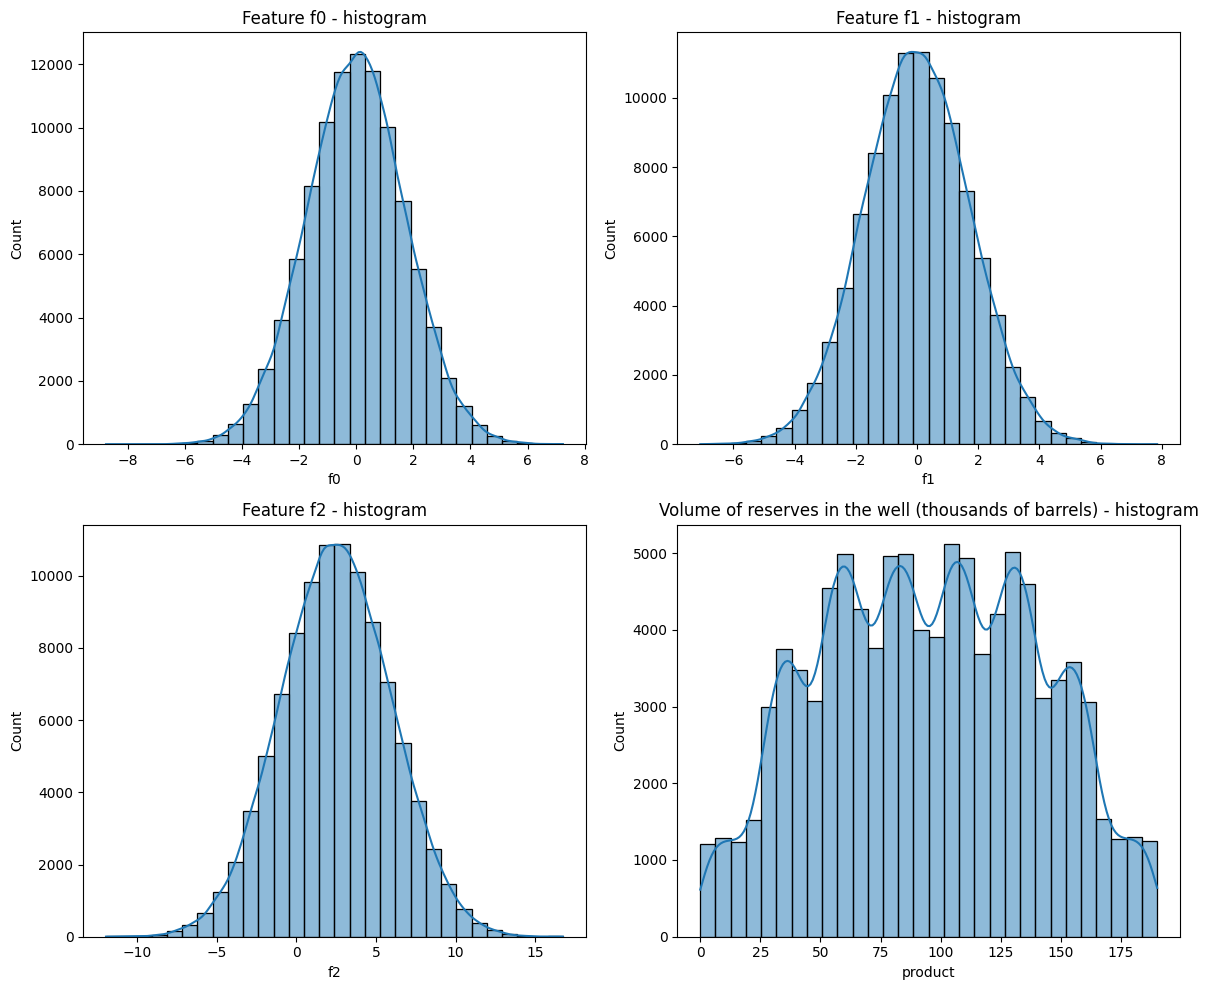

Numerical description of the data

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838
Scatter plot matrix



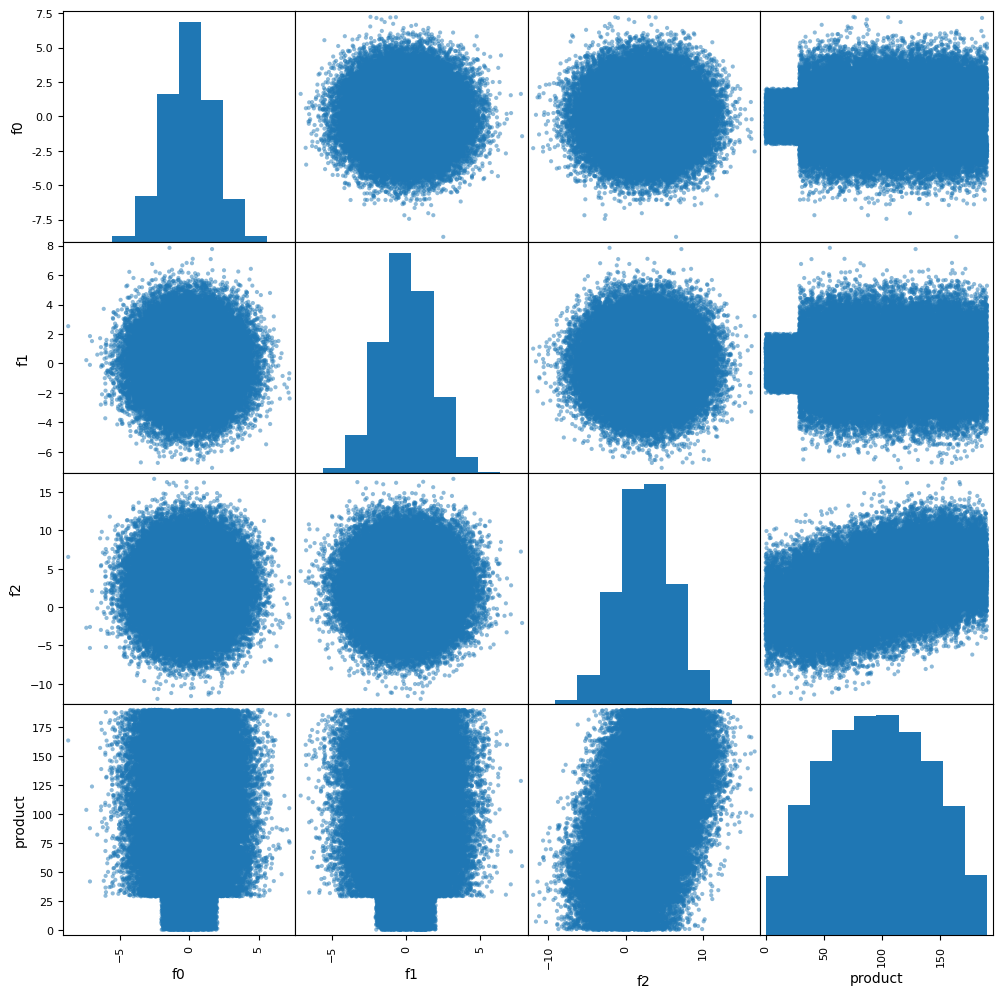


Correlation between features


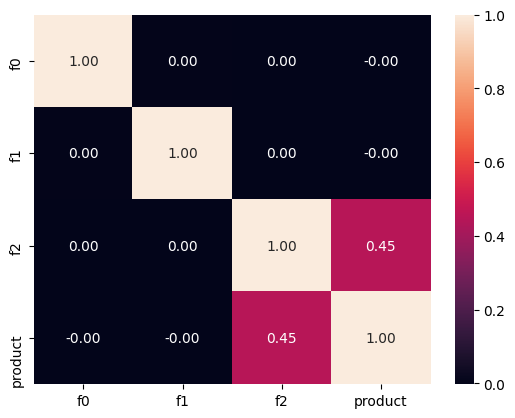

In [13]:
# exploring data for region 2
research(data2)

In [14]:
# function that splits data into training and test sets
def train_test_split_f(df):
    X_train, X_valid, y_train, y_valid = train_test_split(
    df.drop(['product','id'], axis=1),
    df['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)
    print('X_train:', X_train.shape, 
          'X_valid:', X_valid.shape, 
          'y_train:', y_train.shape, 
          'y_valid:', y_valid.shape)
    return X_train, X_valid, y_train, y_valid

In [15]:
X_train0, X_valid0, y_train0, y_valid0 = train_test_split_f(data0)

X_train: (75000, 3) X_valid: (25000, 3) y_train: (75000,) y_valid: (25000,)


In [16]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split_f(data1)

X_train: (75000, 3) X_valid: (25000, 3) y_train: (75000,) y_valid: (25000,)


In [17]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split_f(data2)

X_train: (75000, 3) X_valid: (25000, 3) y_train: (75000,) y_valid: (25000,)


In [18]:
num_columns = ['f0', 'f1', 'f2']

In [19]:
# pipeline for data preprocessing
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(), ['f0', 'f1', 'f2'])])

### Results

1. Data for each region was loaded into separate tables. There are no missing values, no duplicates, and the column names are correct.

2. An exploratory data analysis was performed.

    2.1 Region 0.
    - The feature f0 ranges from -1.4 to 2.4 with an average value of 0.5, with several peaks.
    - The feature f1 ranges from -0.84 to 1.34 with an average value of 0.25, with three peaks.
    - The feature f2 ranges from -12 to 16 with an average value of 2.5, and the distribution is similar to normal.
    - The target feature product ranges from 0 to 190 with an average value of 92.5, with several peaks.
    - Due to the absence of linear dependencies, the Spearman correlation coefficient was calculated. A slight correlation is observed between the target feature and f2.
    - No multicollinearity is observed between the input features.
    
    2.2 Region 1.
    - The feature f0 ranges from -31 to 29 with an average value of 1, with two peaks.
    - The feature f1 ranges from -26 to 18 with an average value of 4.8, and the distribution is similar to normal.
    - The feature f2 ranges from 0 to 5 with an average value of 2, and the values are concentrated around 1, 2, 3, 4, and 5, resembling a discrete distribution.
    - The target feature product ranges from 0 to 138 with an average value of 68.82, and the values are concentrated around six distinct values, resembling a discrete distribution.
    - The Spearman correlation coefficient was calculated. A linear relationship is observed only between the target feature and f2. There is a very strong linear correlation between the target feature and f2 with a correlation coefficient of 0.98, while no correlation exists between other features.
    - No multicollinearity is observed between the input features.

    2.3 Region 2.
    - The feature f0 ranges from -8.8 to 7.2 with an average value of 0, and the distribution is similar to normal.
    - The feature f1 ranges from -7 to 7.8 with an average value of 0, and the distribution is similar to normal.
    - The feature f2 ranges from -12 to 17 with an average value of 2.5, and the distribution is similar to normal.
    - The target feature product ranges from 0 to 190 with an average value of 95, with several peaks.
    - Due to the absence of linear dependencies, the Spearman correlation coefficient was calculated. No correlations between features were found.
    - No multicollinearity is observed between the input features.
    
3. The data was split into test and validation sets.

4. A pipeline for data preparation using scaling was created.


## Model Training and Validation

In [20]:
# final pipeline: data preprocessing and linear models
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
#    ('feature_selection', selector),
    ('models', LinearRegression())
])

param_grid = [
    # dictionary for the LinearRegression() models
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': range(1,12),
        'preprocessor__num': [PolynomialFeatures(degree=2, include_bias=False), \
                              StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': range(1,12),
        'preprocessor__num': [PolynomialFeatures(degree=2, include_bias=False), \
                              StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [PolynomialFeatures(degree=2, include_bias=False), \
                              StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [21]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [22]:
# function for model training and prediction

def model_function(X_train, y_train, X_valid, y_valid, region):
    randomized_search.fit(X_train, y_train)
    model = randomized_search.best_estimator_

    print(region, ': best model and its parameters\n\n', model)
    print ('\nRMSE of the best model using cross-validation:', round(np.abs(randomized_search.best_score_), 2))
    
    y_pred = pd.concat([pd.DataFrame(model.predict(X_valid), columns=['preds']), \
                     pd.DataFrame(y_valid.values, columns=['y_valid'])]
                    , axis=1)
    print('Average predicted reserve of raw materials for the ', region, ':', y_pred['preds'].mean())
    print('Model RMSE on the validation set:', 
      round(mean_squared_error(y_pred['y_valid'], y_pred['preds'], squared=False), 2))
    return y_pred, model

In [23]:
# model and predictions for Region 0
y_pred0, model0 = model_function(X_train0, y_train0, X_valid0, y_valid0, 'Region 0')

Region 0 : best model and its parameters

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=10, random_state=42))])

RMSE of the best model using cross-validation: 37.67
Average predicted reserve of raw materials for the  Region 0 : 92.39877903212405
Model RMSE on the validation set: 37.76


In [24]:
# model and predictions for Region 1
y_pred1, model1 = model_function(X_train1, y_train1, X_valid1, y_valid1, 'Region 1')

Region 1 : best model and its parameters

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=10, random_state=42))])

RMSE of the best model using cross-validation: 0.89
Average predicted reserve of raw materials for the  Region 1 : 68.7128843008152
Model RMSE on the validation set: 0.89


In [25]:
# model and predictions for Region 2
y_pred2, model2 = model_function(X_train2, y_train2, X_valid2, y_valid2, 'Region 2')

Region 2 : best model and its parameters

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=11, random_state=42))])

RMSE of the best model using cross-validation: 38.74
Average predicted reserve of raw materials for the  Region 2 : 94.75964657908159
Model RMSE on the validation set: 38.88


### Results

Models were trained and selected for each region.

1. **Model for Region 0**  
   - RMSE of the best model on cross-validation: 37.67  
   - Average predicted reserve of raw materials for Region 0: 92.39877903212404  
   - RMSE of the model on the validation set: 37.76

2. **Model for Region 1**  
   - RMSE of the best model on cross-validation: 0.89  
   - Average predicted reserve of raw materials for Region 1: 68.7128843008152  
   - RMSE of the model on the validation set: 0.89

3. **Model for Region 2**  
   - RMSE of the best model on cross-validation: 38.74  
   - Average predicted reserve of raw materials for Region 2: 94.75964657908159  
   - RMSE of the model on the validation set: 38.88

The model for Region 1 has the lowest error. The errors of the models for Regions 0 and 2 are almost similar. The average predicted reserve of raw materials for each region is very close to the actual average reserve for all three regions.


## Preparing for Profit Calculation

In [26]:
TOTAL_SPOTS = 500
NEEDED_SPOTS = 200
BUDGET = 10000000000
T_BARREL_PRICE= 450000
MAX_LOSS_PROBABILITY = 0.025
min_volume = BUDGET / NEEDED_SPOTS / T_BARREL_PRICE 
print('Sufficient volume of raw materials for the break-even development of a new well (thousands of barrels):', \
      round(min_volume, 2))

Sufficient volume of raw materials for the break-even development of a new well (thousands of barrels): 111.11


In [27]:
print('Average reserve of raw materials in the region 0:', round(data0['product'].mean(),2))
print('Average reserve of raw materials in the region 1:', round(data1['product'].mean(), 2))
print('СAverage reserve of raw materials in the region 2:', round(data2['product'].mean(), 2))

Average reserve of raw materials in the region 0: 92.5
Average reserve of raw materials in the region 1: 68.83
СAverage reserve of raw materials in the region 2: 95.0


In [28]:
# function for profit calculation
def revenue(valid, preds, count):
    preds_sorted = preds.sort_values(ascending=False) 
    selected = valid[preds_sorted.index][:count]
    global T_BARREL_PRICE
    return T_BARREL_PRICE * selected.sum()

### Results

#### Preparing for Profit Calculation
- All key values for calculations were stored in separate variables.
- The sufficient volume of raw materials for the break-even development of a new well was calculated: 111.11 thousand barrels.
- In all three regions, the predicted volume of raw materials is lower than the sufficient volume for break-even well development (in Region 1, it is significantly lower):
    - Average reserve of raw materials in Region 0: 92.5
    - Average reserve of raw materials in Region 1: 68.83
    - Average reserve of raw materials in Region 2: 95.0

#### A function for profit calculation was written based on selected wells and model predictions.
- Wells with the maximum predicted values were selected.
- The target values of the raw material volume corresponding to these predictions were summed.
- Profit was calculated for the obtained volume of raw materials.


## Profit and Risk Calculation

In [29]:
# function for calculating average revenue, average profit, confidence interval, and probability of loss

def values_function(y_pred, region):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        valid_subsample = pd.Series(y_pred['y_valid']).sample(n=TOTAL_SPOTS, replace=True, random_state=state)
        preds_subsample = pd.Series(y_pred['preds'])[valid_subsample.index] 
        values.append(revenue(valid_subsample, preds_subsample, NEEDED_SPOTS))

    values = pd.Series(values)

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean = values.mean()
    print(region)
    print("Average revenue:", round(mean))
    print("Average profit:", round(mean - BUDGET))
    print("95% confidence interval of profit (negative profit is considered a loss):", round(lower - BUDGET), ",", round(upper - BUDGET))

    # вероятность убытков
    print("Probability of loss:", round(values[values < BUDGET].count() / values.count() * 100, 2), "%")

In [30]:
# average revenue, average profit, confidence interval, and probability of loss for Region 0 
values_function(y_pred0, 'Region 0')

Region 0
Average revenue: 10436118233
Average profit: 436118233
95% confidence interval of profit (negative profit is considered a loss): -116231613 , 966504181
Probability of loss: 6.1 %


In [31]:
# average revenue, average profit, confidence interval, and probability of loss for Region 1
values_function(y_pred1, 'Region 1')

Region 1
Average revenue: 10489661254
Average profit: 489661254
95% confidence interval of profit (negative profit is considered a loss): 55116177 , 905762650
Probability of loss: 1.1 %


In [32]:
# average revenue, average profit, confidence interval, and probability of loss for Region 2
values_function(y_pred2, 'Region 2')

Region 2
Average revenue: 10603514836
Average profit: 603514836
95% confidence interval of profit (negative profit is considered a loss): 85659911 , 1153069187
Probability of loss: 0.7 %


### Conclusion
Risks and profits were calculated for each region.

1. **Region 0**
   - Average profit: 436,118,233
   - 95% confidence interval of profit (negative profit is considered a loss): -116,231,613, 966,504,181
   - Probability of loss: 6.1%

2. **Region 1**
   - Average profit: 489,661,254
   - 95% confidence interval of profit (negative profit is considered a loss): 55,116,177, 905,762,650
   - Probability of loss: 1.1%

3. **Region 2**
   - Average profit: 603,514,836
   - 95% confidence interval of profit (negative profit is considered a loss): 85,659,911, 1,153,069,187
   - Probability of loss: 0.7%

*Regions with a loss probability of less than 2.5%:* Region 1, Region 2  
*The region with the highest average profit among them:* **Region 2**


## Conclusions

1. Data for three regions were loaded. The data were checked for missing values and duplicates, exploratory data analysis was performed, and relationships and correlations were studied. The data were then prepared for machine learning—datasets were split into training and validation sets, and a pipeline was created for data scaling.

2. Models were trained and selected for each region.

- **Model for Region 0**
    - RMSE of the best model on cross-validation: 37.67
    - Average predicted reserve of raw materials for Region 0: 92.39877903212404
    - RMSE of the model on the validation set: 37.76

- **Model for Region 1**
    - RMSE of the best model on cross-validation: 0.89
    - Average predicted reserve of raw materials for Region 1: 68.7128843008152
    - RMSE of the model on the validation set: 0.89

- **Model for Region 2**
    - RMSE of the best model on cross-validation: 38.74
    - Average predicted reserve of raw materials for Region 2: 94.75964657908159
    - RMSE of the model on the validation set: 38.88

The model for Region 1 has the lowest error. The errors of the models for Regions 0 and 2 are similar. The average predicted reserve of raw materials for each region is very close to the actual average reserve for all three regions.

3. Preparation for profit calculation was performed. The sufficient volume of raw materials for the break-even development of a new well was calculated, which is 111.11 thousand barrels. In all three regions, the predicted volume of raw materials is lower than the sufficient volume for break-even well development (in Region 1, it is significantly lower):
   - Average reserve of raw materials in Region 0: 92.5
   - Average reserve of raw materials in Region 1: 68.83
   - Average reserve of raw materials in Region 2: 95.0

A function was written to calculate profit for the selected wells and model predictions: wells with the maximum predicted values were selected, the target values of raw material volume corresponding to these predictions were summed, and the profit for the obtained volume of raw materials was calculated.

4. Risks and profits were calculated for each region.

- **Region 0**
    - Average profit: 436,118,233
    - 95% confidence interval of profit (negative profit is considered a loss): -116,231,613, 966,504,181
    - Probability of loss: 6.1%

- **Region 1**
    - Average profit: 489,661,254
    - 95% confidence interval of profit (negative profit is considered a loss): 55,116,177, 905,762,650
    - Probability of loss: 1.1%

- **Region 2**
    - Average profit: 603,514,836
    - 95% confidence interval of profit (negative profit is considered a loss): 85,659,911, 1,153,069,187
    - Probability of loss: 0.7%

*Regions with a probability of loss less than 2.5%: Region 1, Region 2*

**For well development, Region 2 is recommended, as it has the highest average profit among regions with a loss probability of less than 2.5%.**
